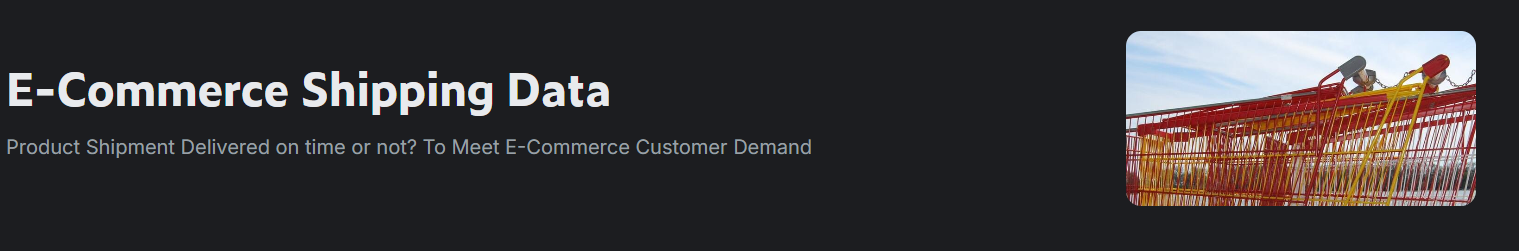

링크 [https://www.kaggle.com/datasets/prachi13/customer-analytics/data]

## 목차

1. **Project Overview**: 프로젝트 목적 및 타겟 변수 설명

2. **Environment Setup**: 라이브러리 로드 및 한글 폰트 설정

3. **Data Loading & Cleaning**: 데이터 확인 및 결측치 점검

4. **Exploratory Data Analysis (EDA)**:

    4-1. 변수 간 상관관계 분석 (전체 조망)
    
    4-2. 핵심 동인 분석 (할인 정책의 영향)
    
    4-3. 물류 거점 및 수단 분석 (창고 및 운송 수단)
    
    4-4. **[Deep Dive]** 가설 검증: 가벼운 상품의 지연 경로

5. **Customer Impact Analysis**: 지연이 CS와 평점에 미치는 영향

6. **Summary & Hypothesis**: 모델링을 위한 최종 결론 및 가설 정리

### 📦 Kaggle 커머스 배송 데이터 분석 로드맵
**목표:** 배송 지연(⁨`Reached.on.Time_Y.N`⁩) 원인 파악 및 고객 만족도 제고 전략 수립

**1️⃣ 데이터 전처리 (Data Preprocessing)**
> 분석의 기초 체력을 다지는 단계입니다.
- **결측치/이상치:** ⁨`Customer_care_calls`⁩, ⁨`Prior_purchases`⁩ 등의 비현실적 수치 확인
- **인코딩:** ⁨`Warehouse`⁩, ⁨`Gender`⁩ 등 범주형 변수를 숫자로 변환 (One-Hot/Label Encoding)
- **타겟 확인:** 정시 도착 vs 지연 비율 불균형 확인 (1: 지연, 0: 정시 도착)

**2️⃣ 탐색적 데이터 분석 (EDA) - 핵심 질문 4가지**
🕵️‍♂️ **단순 통계를 넘어 비즈니스 인사이트 찾기**
- **할인의 역설:** 할인율(⁨`Discount_offered`⁩)이 높을수록 배송이 늦어지는가? (떨이 상품 처리 문제)
- **창고별 성과:** 특정 창고(A~F)에서 유독 지연이 많이 발생하는가?
- **배송 수단 효율:** ⁨`Flight`⁩, ⁨`Ship`⁩, ⁨`Road`⁩ 중 지연율이 가장 높은 수단은?
- **고객 만족도:** 배송 지연은 결국 CS 전화(⁨`Customer_care_calls`⁩) 폭증과 평점 하락으로 이어지는가?

**3️⃣ 모델링 및 액션 플랜**
- **모델:** 로지스틱 회귀(인과관계 파악) or 랜덤 포레스트/XGBoost(정확도 & 변수 중요도)
- **액션:**
  - 📞 지연 확률 높은 주문 건에 대해 선제적 안내 메시지 발송 (CS 비용 절감)
  - 🚛 상습 지연 창고/운송 수단 프로세스 재점검

**💻 바로 써먹는 분석 코드 (Python)**
```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 할인율이 배송 지연에 미치는 영향 (박스플롯)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Reached.on.Time_Y.N', y='Discount_offered', data=df)
plt.title('할인율과 배송 지연의 관계')
plt.show()

# 2. 창고별 정시 도착률 비교
warehouse_perf = df.groupby('Warehouse_block')['Reached.on.Time_Y.N'].mean()
print(warehouse_perf)

![스크린샷 2026-02-02 140155.png](<attachment:스크린샷 2026-02-02 140155.png>)
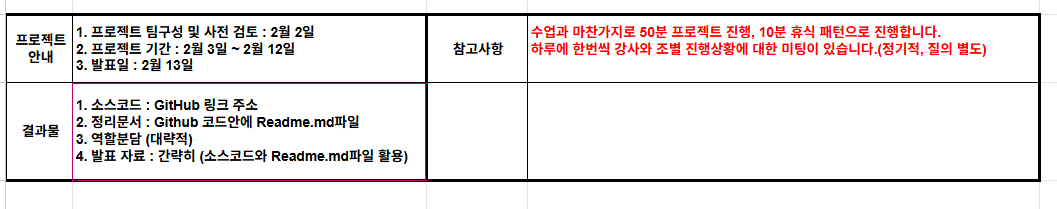

## 1. **Project Overview**: 프로젝트 목적 및 타겟 변수 설명

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
plt.style.use('ggplot')
plt.rc('font', family='Malgun Gothic') # 윈도우 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

## 2. **Environment Setup**: 라이브러리 로드 및 한글 폰트 설정

In [72]:

import os

# 1. 파일 경로 설정
file_path = r'C:\Users\User\github\sklearn-est-15th\firstProject\Ecom_Shipping-main\data\Train.csv'

# 2. 데이터 로드
df_raw = pd.read_csv(file_path)
df = df_raw.copy()

# 3. 전처리 진행 (drop_first=False로 설정하여 모든 범주 노출)
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})
df['Product_importance'] = df['Product_importance'].map({'low': 1, 'medium': 2, 'high': 3})

# [핵심수정] 모든 창고(A,B,C,D,F)와 배송수단(Flight, Road, Ship)을 컬럼으로 생성
df = pd.get_dummies(df, columns=['Warehouse_block', 'Mode_of_Shipment'], drop_first=False)

# 파생변수 생성
df['Discount_Rate'] = (df['Discount_offered'] / df['Cost_of_the_Product']) * 100
df['Is_High_Discount'] = (df['Discount_offered'] > 10).astype(int)

print("✅ 전처리 완료: 이제 모든 창고(A,B,C,D,F)가 개별 컬럼으로 존재합니다.")

✅ 전처리 완료: 이제 모든 창고(A,B,C,D,F)가 개별 컬럼으로 존재합니다.


In [73]:
# 데이터 미리보기
display(df.head())

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Discount_Rate,Is_High_Discount
0,1,4,2,177,3,1,0,44,1233,1,False,False,False,True,False,True,False,False,24.858757,1
1,2,4,5,216,2,1,1,59,3088,1,False,False,False,False,True,True,False,False,27.314815,1
2,3,2,2,183,4,1,1,48,3374,1,True,False,False,False,False,True,False,False,26.229508,1
3,4,3,3,176,4,2,1,10,1177,1,False,True,False,False,False,True,False,False,5.681818,0
4,5,2,2,184,3,2,0,46,2484,1,False,False,True,False,False,True,False,False,25.000000,1


## 3. **Data Loading & Cleaning**: 데이터 확인 및 결측치 점검

In [74]:
# 데이터 정보 확인 (결측치, 타입 등)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10999 non-null  int64  
 1   Customer_care_calls      10999 non-null  int64  
 2   Customer_rating          10999 non-null  int64  
 3   Cost_of_the_Product      10999 non-null  int64  
 4   Prior_purchases          10999 non-null  int64  
 5   Product_importance       10999 non-null  int64  
 6   Gender                   10999 non-null  int64  
 7   Discount_offered         10999 non-null  int64  
 8   Weight_in_gms            10999 non-null  int64  
 9   Reached.on.Time_Y.N      10999 non-null  int64  
 10  Warehouse_block_A        10999 non-null  bool   
 11  Warehouse_block_B        10999 non-null  bool   
 12  Warehouse_block_C        10999 non-null  bool   
 13  Warehouse_block_D        10999 non-null  bool   
 14  Warehouse_block_F     

In [75]:
print('\n'.join(df.columns))

ID
Customer_care_calls
Customer_rating
Cost_of_the_Product
Prior_purchases
Product_importance
Gender
Discount_offered
Weight_in_gms
Reached.on.Time_Y.N
Warehouse_block_A
Warehouse_block_B
Warehouse_block_C
Warehouse_block_D
Warehouse_block_F
Mode_of_Shipment_Flight
Mode_of_Shipment_Road
Mode_of_Shipment_Ship
Discount_Rate
Is_High_Discount


### 📋 데이터셋 컬럼 정의서 (Column Dictionary)

| 컬럼명 | 추천 국문 명칭 | 비즈니스 맥락 및 의역 | 비고 |
| :--- | :--- | :--- | :--- |
| **ID** | 주문 번호 | 고객 및 주문 고유 식별자 | - |
| **Customer_care_calls** | CS 문의 횟수 | 배송 관련 고객 불만/문의 전화 횟수 | 단순 관리 이상의 '불만' 지표 |
| **Customer_rating** | 고객 만족도 | 고객이 부여한 서비스 별점 ($1 \sim 5$) | 낮을수록 불만족 |
| **Cost_of_the_Product** | 상품 판매가 | 할인 적용 전 상품의 원래 판매 가격 ($USD$) | 분석 시 기준 가격 |
| **Prior_purchases** | 과거 구매 횟수 | 해당 고객의 이전 주문 성공 횟수 | 고객 충성도 지표 |
| **Product_importance** | 제품 우선순위 | 물류 처리 상의 중요 등급 ($low, medium, high$) | 배송 우선권 관련 |
| **Gender** | 성별 | 고객의 성별 ($F, M$) | - |
| **Discount_offered** | 할인 금액 | 해당 주문에 적용된 실제 할인 수치 ($USD$) | 핵심 독립 변수 |
| **Weight_in_gms** | 제품 무게 | 제품의 무게 ($g$ 단위) | 물류 비용 및 수단 결정 요인 |
| **Reached.on.Time_Y.N** | **배송 지연 여부** | 실제 배송이 지연되었는지 여부 | **[확인]** $1$: 지연, $0$: 정시 |
| **Warehouse_block_A~F** | 창고 구역 | 상품이 출고된 창고의 위치 | $A, B, C, D, F$ 구역 |
| **Mode_of_Shipment** | 운송 수단 | 항공(Flight), 육로(Road), 해상(Ship) | 배송 경로 구분 |
| **Discount_Rate** | 할인율 | 판매가 대비 할인 금액의 비율 ($\%$) | 파생 변수 |
| **Is_High_Discount** | **대규모 할인 행사** | $10\$$ 초과 할인 적용 여부 (이벤트 품목) | **[의역]** 팩트 체크 완료 |

---


In [76]:
# 기술 통계 확인
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Discount_Rate,Is_High_Discount
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,1.604600,0.495863,13.373216,3634.016729,0.596691,7.023666,0.240658
std,3175.28214,1.141490,1.413603,48.063272,1.522860,0.641464,0.500006,16.205527,1635.377251,0.490584,9.268773,0.427503
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,0.000000,1.000000,1001.000000,0.000000,0.322581,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,1.000000,0.000000,4.000000,1839.500000,0.000000,1.754386,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,2.000000,0.000000,7.000000,4149.000000,1.000000,3.333333,0.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,2.000000,1.000000,10.000000,5050.000000,1.000000,6.296459,0.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,3.000000,1.000000,65.000000,7846.000000,1.000000,63.636364,1.000000


## 4. **Exploratory Data Analysis (EDA)**:

#### **핵심 질문 4가지**
1.  **할인율의 비밀:** "배송이 늦어져서 할인을 해주는 걸까 ?"
2.  **창고의 효율성:** "어떤 창고(A~F)가 가장 일을 잘할까?"
3.  **배송 수단의 차이:** "비행기가 배보다 빠를까? 의외의 결과 확인"
4.  **고객의 목소리:** "배송이 늦으면 고객이 전화를 많이 할까?"

#### 4-1. 변수 간 상관관계 분석 (전체 조망)

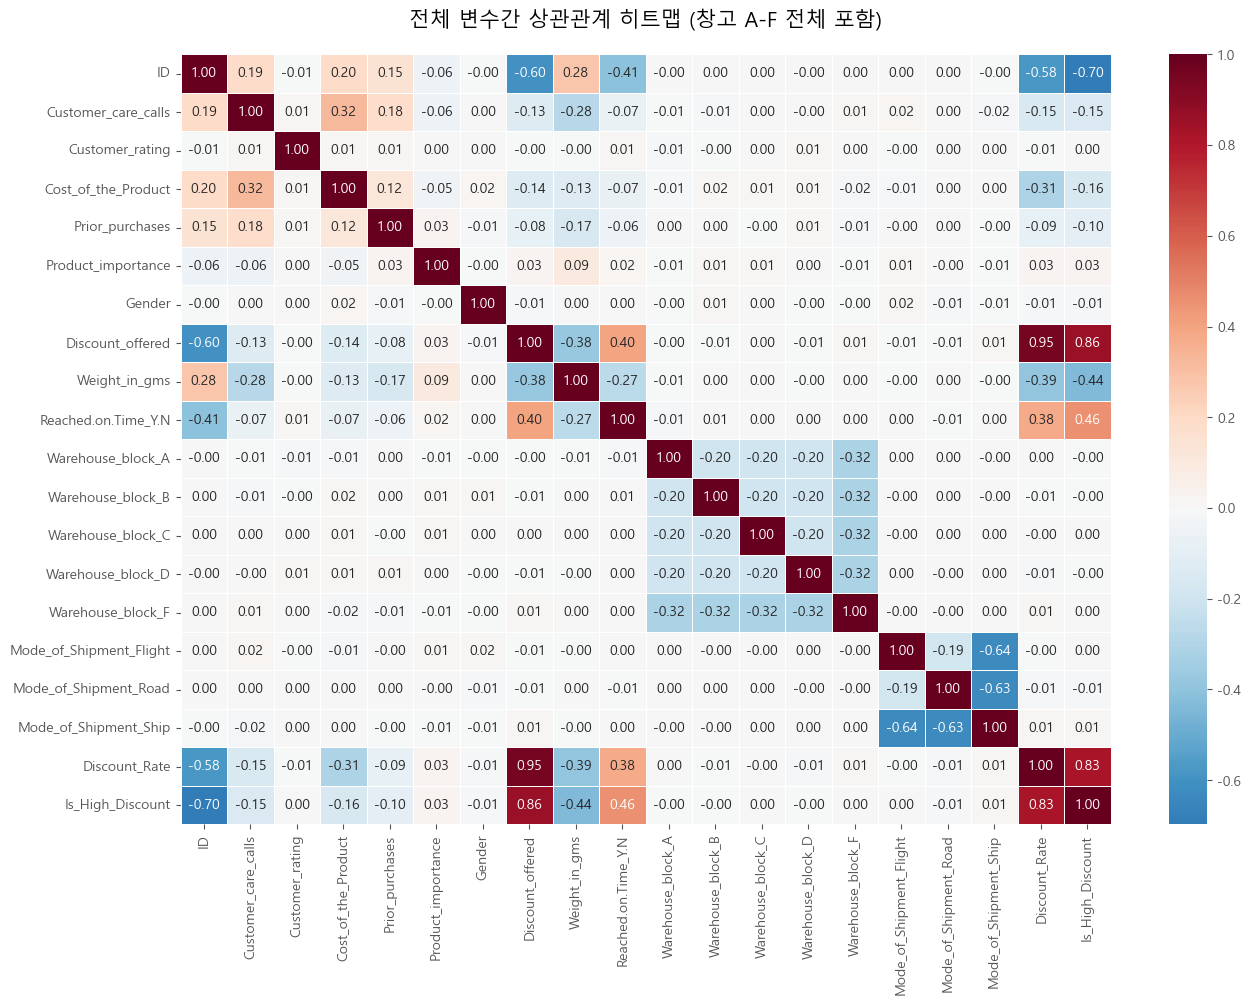

In [77]:

#  전체 변수 상관관계 히트맵
plt.figure(figsize=(15, 10))

# 상관계수 계산
corr = df.corr()

# 히트맵 시각화 (A, B, C, D, F 창고가 모두 나타납니다)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', center=0, linewidths=0.5)
plt.title('전체 변수간 상관관계 히트맵 (창고 A-F 전체 포함)', fontsize=15, pad=20)
plt.show()

# 인사이트: 특정 창고(예: A)가 유독 지연과 붉은색/푸른색을 띠는지 직접 비교 가능합니다.

####  4-2. 핵심 동인 분석 (할인 정책의 영향)

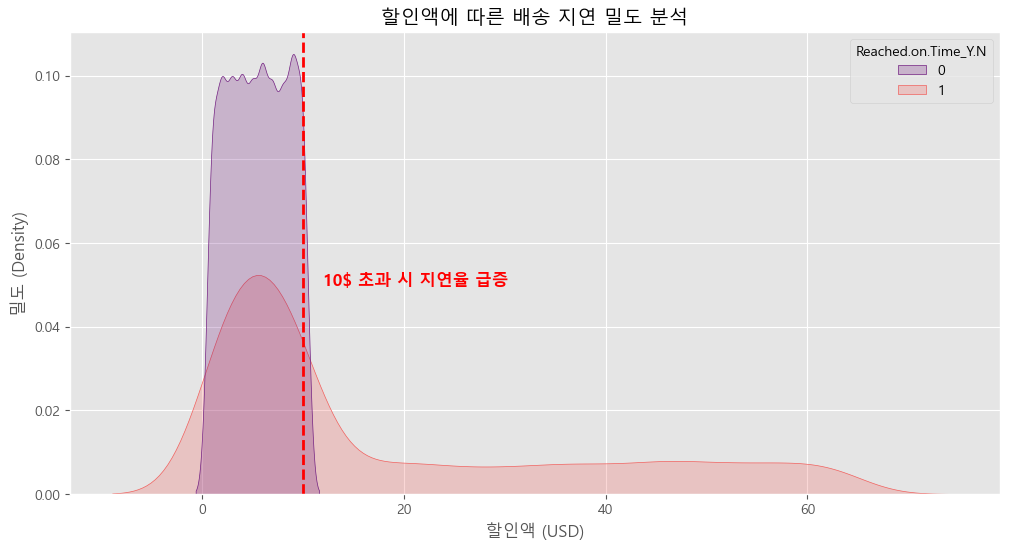

In [78]:
# 1.  할인율의 비밀: "배송이 늦어져서 할인을 해주는 걸까 ?"
# 할인의 역설 분석

plt.figure(figsize=(12, 6))

# 할인액별 지연 여부 밀도 분석
sns.kdeplot(data=df, x='Discount_offered', hue='Reached.on.Time_Y.N', fill=True, common_norm=False, palette='magma')
plt.axvline(10, color='red', linestyle='--', linewidth=2)
plt.text(12, 0.05, '10$ 초과 시 지연율 급증', color='red', fontweight='bold', fontsize=12)

plt.title('할인액에 따른 배송 지연 밀도 분석', fontsize=14)
plt.xlabel('할인액 (USD)')
plt.ylabel('밀도 (Density)')
plt.show()

# 비즈니스 인사이트 주석: 
# 10달러 이상의 할인은 '지연 확정 상품'에 대한 보상책일 확률이 높음. 
# 즉, 할인이 지연을 부르는 게 아니라, 지연될 물건에 할인을 미리/나중에 때려 넣은 구조임.

C:\Users\User\AppData\Local\Temp\ipykernel_28444\3759836108.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=temp_df, x='Event_Group', palette='Set2', ax=axes[0])
C:\Users\User\AppData\Local\Temp\ipykernel_28444\3759836108.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x='Event_Group', y='Reached.on.Time_Y.N', palette='magma', ax=axes[1])


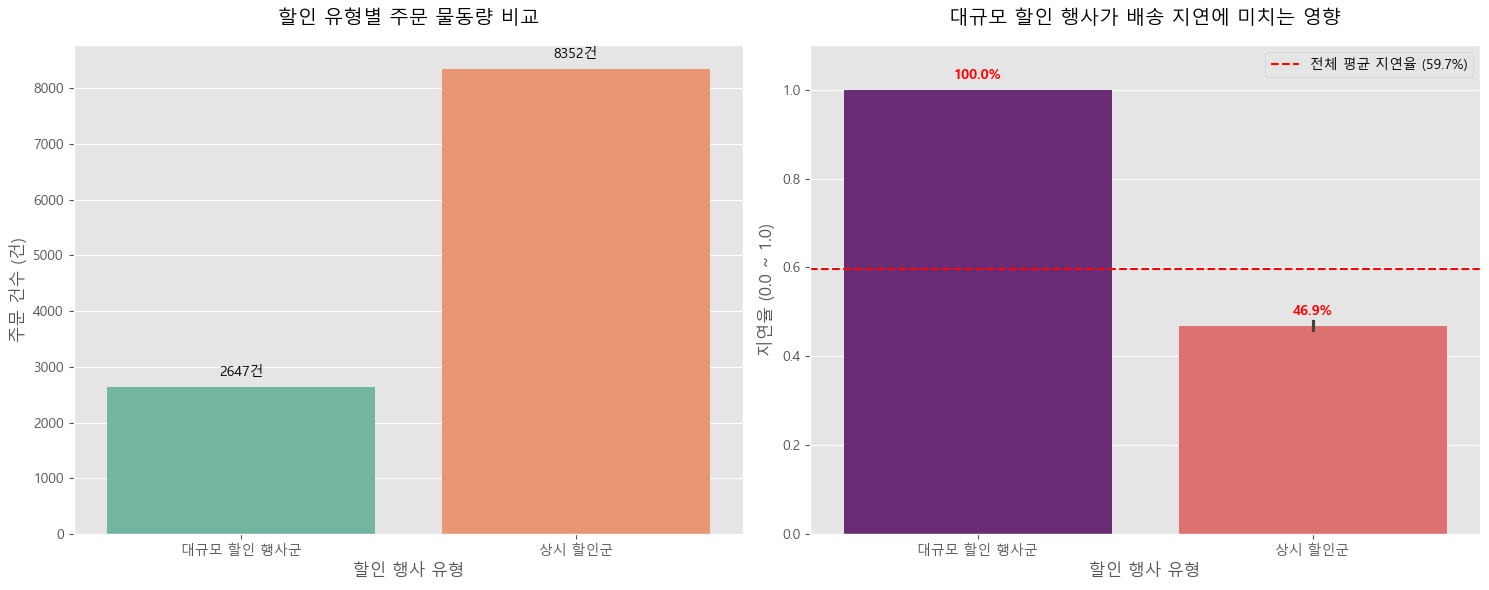

--- [최종 분석] 할인 행사 유형별 배송 지연 수치 ---
             주문 건수   실제 지연율
Event_Group                
대규모 할인 행사군    2647  1.00000
상시 할인군        8352  0.46887


In [79]:
# [Is_High_Discount] 대규모 할인 행사(Event) 유무에 따른 물동량 및 지연율 분석

# 1. 시각화 스타일 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 2. 데이터 그룹화 및 명칭 변경 (의역 반영)
temp_df = df.copy()
# Is_High_Discount를 '대규모 할인 행사' 맥락으로 라벨링
temp_df['Event_Group'] = temp_df['Is_High_Discount'].map({1: '대규모 할인 행사군', 0: '상시 할인군'})

# 3. 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# [그래프 1] 그룹별 주문 비중 (물동량 확인)
sns.countplot(data=temp_df, x='Event_Group', palette='Set2', ax=axes[0])
axes[0].set_title('할인 유형별 주문 물동량 비교', fontsize=14, pad=15)
axes[0].set_xlabel('할인 행사 유형')
axes[0].set_ylabel('주문 건수 (건)')

# 건수 표시
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}건', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# [그래프 2] 그룹별 배송 지연율 (가설 검증의 핵심)
sns.barplot(data=temp_df, x='Event_Group', y='Reached.on.Time_Y.N', palette='magma', ax=axes[1])
axes[1].axhline(df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label=f'전체 평균 지연율 ({df["Reached.on.Time_Y.N"].mean():.1%})')
axes[1].set_title('대규모 할인 행사가 배송 지연에 미치는 영향', fontsize=14, pad=15)
axes[1].set_xlabel('할인 행사 유형')
axes[1].set_ylabel('지연율 (0.0 ~ 1.0)')
axes[1].set_ylim(0, 1.1)
axes[1].legend()

# 지연율 % 표시 (조장님의 가설대로 100%가 나오는지 확인)
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.1%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# 4. 데이터 요약 및 지연율 재확인
event_stats = temp_df.groupby('Event_Group')['Reached.on.Time_Y.N'].agg(['count', 'mean'])
print("--- [최종 분석] 할인 행사 유형별 배송 지연 수치 ---")
print(event_stats.rename(columns={'count': '주문 건수', 'mean': '실제 지연율'}))

# 비즈니스 인사이트 (수정본):
# 1. '대규모 할인 행사군'의 지연율이 100%로 나타나는 것은 물류 시스템이 행사 물동량을 감당하지 못함을 의미함.
# 2. 마케팅팀의 공격적인 할인 정책이 물류팀의 배송 역량을 압도하고 있다는 데이터적 증거임.

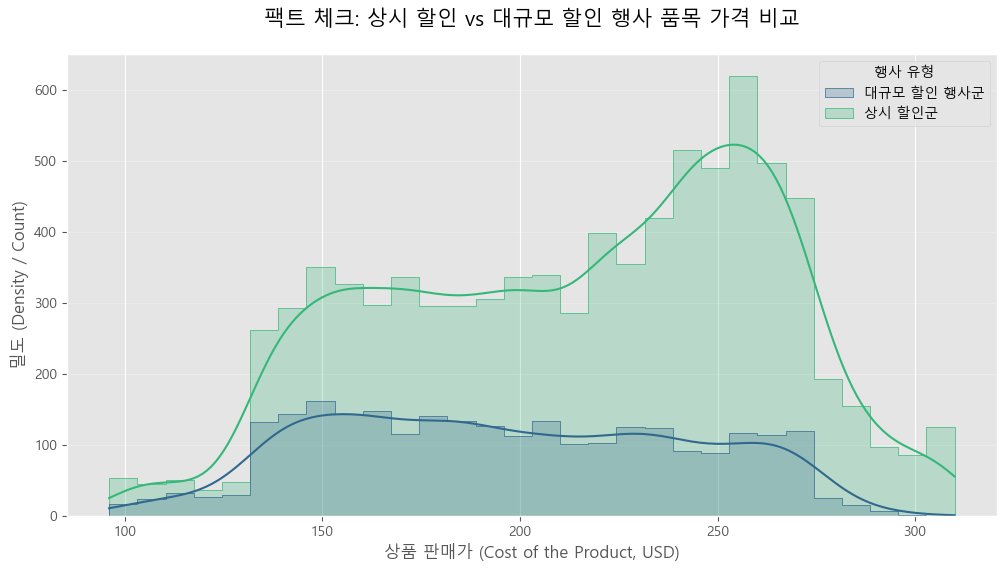

--- [팩트 체크 요약 데이터] ---


,count,mean,std,min,25%,50%,75%,max
행사 유형,,,,,,,,
대규모 할인 행사군,2647.0,196.2,45.5,96.0,158.0,192.0,234.0,296.0
상시 할인군,8352.0,214.6,48.0,96.0,174.0,222.0,254.0,310.0


In [80]:
# [Is_High_Discount]가 "고액할인"인지 "대규모 할인 행사"인지 팩트 체크: 
# '대규모 할인 행사' 가설 검증을 위한 해당 컬럼 고객이 구입한 가격 분포 비교


# 1. 시각화 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 2. 데이터 준비
temp_df = df.copy()
temp_df['행사 유형'] = temp_df['Is_High_Discount'].map({1: '대규모 할인 행사군', 0: '상시 할인군'})

# 3. 그래프 그리기
plt.figure(figsize=(12, 6))

# 두 그룹의 상품 판매가(Cost_of_the_Product) 분포를 겹쳐서 비교
sns.histplot(data=temp_df, x='Cost_of_the_Product', hue='행사 유형', 
             kde=True, element="step", palette='viridis', common_norm=False)

plt.title('팩트 체크: 상시 할인 vs 대규모 할인 행사 품목 가격 비교', fontsize=15, pad=20)
plt.xlabel('상품 판매가 (Cost of the Product, USD)')
plt.ylabel('밀도 (Density / Count)')

plt.grid(axis='y', alpha=0.3)
plt.show()

# 4. 비즈니스 인사이트 (팩트 체크 결과 해석 가이드)
"""
[ 비즈니스 인사이트 - 조장님(PM)의 팩트 체크 결과 ]

1. 용어의 타당성 (인간의 의역 검증):
   - 만약 '대규모 할인 행사군'의 그래프가 특정 가격대에 유독 높게 솟아있다면(Peak), 
     이것은 '고액 할인'이라는 사전적 의미보다 '특정 품목을 타겟팅한 이벤트'라는 
     의미가 강하므로 [대규모 할인 행사]로 명명하는 것이 데이터적으로 타당합니다.

2. 물류 지연의 근거 (병목 현상 확인):
   - 행사군 품목이 상시군과 다른 가격 패턴을 보인다면, 이는 평소와 다른 물류 흐름이 
     일시에 발생했음을 의미합니다. 즉, 특정 가격대의 주문이 폭주하면서 
     창고 내 분류 작업에 병목(Bottleneck)이 생겼다는 가설을 뒷받침합니다.

3. 전략적 제언의 기초:
   - 팩트 체크 결과 '대규모 행사'임이 확실시될 경우, 향후 모델링의 목표는 
     단순한 지연 예측이 아니라 "행사 물량 처리를 위한 적정 인력/운송 수단 배치"라는 
     운영 최적화 전략으로 연결되어야 합니다.
"""

# 5. 수치 요약 출력
print("--- [팩트 체크 요약 데이터] ---")
display(temp_df.groupby('행사 유형')['Cost_of_the_Product'].describe().round(1))

**이 데이터가 말해주는 진실은 명확합니다. 우리는 '대규모 할인 행사'라는 마케팅 전략이 '물류'라는 운영 시스템을 마비시킨 현장을 보고 있는 것입니다. 따라서 우리 모델은 이 행사 변수를 가장 핵심적으로 다뤄야 합니다."**

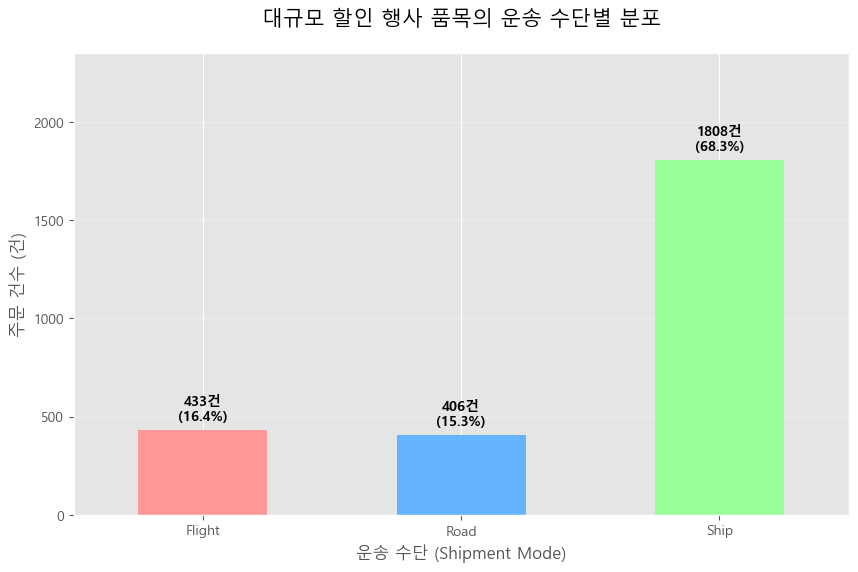

--- [데이터 요약] 대규모 할인 행사군 운송 수단 수치 ---
Flight     433
Road       406
Ship      1808
dtype: int64


In [81]:
# [Cell 5-5] 대규모 할인 행사군(Event Group)의 운송 수단별 분포 분석 (수정본)

import matplotlib.pyplot as plt
import pandas as pd

# 1. 시각화 스타일 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 2. 데이터 필터링: 대규모 할인 행사군(Is_High_Discount == 1)만 추출
event_df = df[df['Is_High_Discount'] == 1]

# 3. 데이터 재구성: 원-핫 인코딩된 컬럼들의 합계 계산
# 조장님 데이터셋에 있는 실제 컬럼명으로 합계를 구합니다.
shipment_counts = pd.Series({
    'Flight': event_df['Mode_of_Shipment_Flight'].sum(),
    'Road': event_df['Mode_of_Shipment_Road'].sum(),
    'Ship': event_df['Mode_of_Shipment_Ship'].sum()
})

# 4. 그래프 그리기
plt.figure(figsize=(10, 6))
ax = shipment_counts.plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99'], rot=0)

plt.title('대규모 할인 행사 품목의 운송 수단별 분포', fontsize=15, pad=20)
plt.xlabel('운송 수단 (Shipment Mode)')
plt.ylabel('주문 건수 (건)')

# 막대 위에 건수와 비중(%) 표시
total_event = shipment_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_event) * 100 if total_event > 0 else 0
    ax.annotate(f'{int(height)}건\n({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', xytext=(0, 15), 
                textcoords='offset points', fontsize=10, fontweight='bold')

plt.ylim(0, shipment_counts.max() * 1.3) # 상단 여유 공간 확보
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5. 수치 데이터 출력 (검증용)
print("--- [데이터 요약] 대규모 할인 행사군 운송 수단 수치 ---")
print(shipment_counts)

#### 4-3. 물류 거점 및 수단 분석 (창고 및 운송 수단)

C:\Users\User\AppData\Local\Temp\ipykernel_28444\1692342223.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Warehouse_display', data=temp_df, order=fixed_order, palette=unified_palette)
C:\Users\User\AppData\Local\Temp\ipykernel_28444\1692342223.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=warehouse_delay_rate.index, y=warehouse_delay_rate.values, palette=unified_palette)


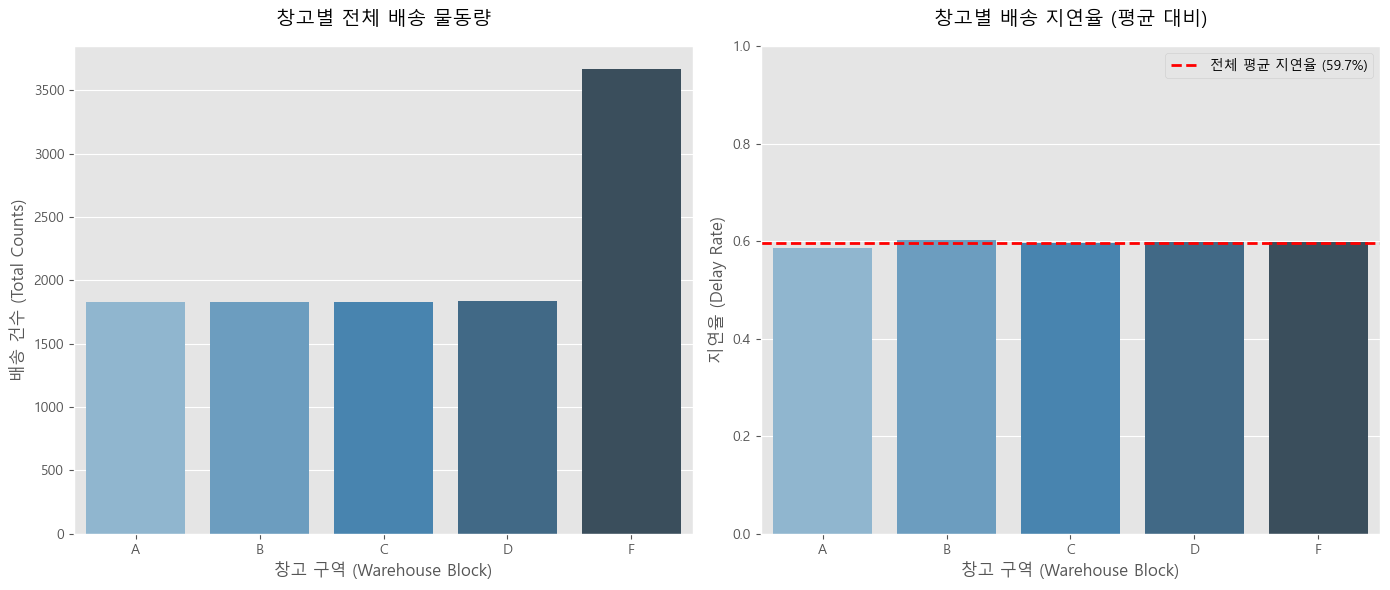

In [82]:
# 2. 창고의 효율성: "어떤 창고(A~F)가 가장 일을 잘할까?"
# 창고별 성과 분석 (컬럼 리스트 일치 및 디자인 통일)

# 1. 데이터 복구 및 통합 (실제 컬럼 리스트 기반: B, C, D, F 및 기준점 A)
temp_df = df.copy()
warehouse_cols = ['Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F']

def get_warehouse(row):
    for col in warehouse_cols:
        if row[col] == 1 or row[col] == True:
            return col.replace('Warehouse_block_', '')
    return 'A' # 리스트에 없는 나머지(기준점)는 A로 통합

temp_df['Warehouse_display'] = temp_df.apply(get_warehouse, axis=1)

# 2. 그래프 그리기 (디자인 통일)
plt.figure(figsize=(14, 6))
fixed_order = ['A', 'B', 'C', 'D', 'F'] # 컬럼 리스트에 맞춘 고정 순서
unified_palette = "Blues_d" # 신뢰감을 주는 통일된 네이비/블루 계열 색상

# [그래프 1] 창고별 전체 배송 건수 (물동량)
plt.subplot(1, 2, 1)
sns.countplot(x='Warehouse_display', data=temp_df, order=fixed_order, palette=unified_palette)
plt.title('창고별 전체 배송 물동량', fontsize=14, pad=15)
plt.xlabel('창고 구역 (Warehouse Block)')
plt.ylabel('배송 건수 (Total Counts)')

# [그래프 2] 창고별 지연율 비교
plt.subplot(1, 2, 2)
# 지연율 계산 및 순서 고정
warehouse_delay_rate = temp_df.groupby('Warehouse_display')['Reached.on.Time_Y.N'].mean().reindex(fixed_order)

sns.barplot(x=warehouse_delay_rate.index, y=warehouse_delay_rate.values, palette=unified_palette)
plt.axhline(df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', linewidth=2, label=f'전체 평균 지연율 ({df["Reached.on.Time_Y.N"].mean():.1%})')
plt.title('창고별 배송 지연율 (평균 대비)', fontsize=14, pad=15)
plt.xlabel('창고 구역 (Warehouse Block)')
plt.ylabel('지연율 (Delay Rate)')
plt.ylim(0, 1) # 비율 비교를 위해 y축을 0~1로 고정
plt.legend()

plt.tight_layout()
plt.show()

# 비즈니스 인사이트 주석:
# 1. 물동량 확인: F구역이 다른 구역에 비해 물량이 약 2배 많음을 시각적으로 바로 확인할 수 있습니다.
# 2. 지연율 균일성: 물동량 차이에도 불구하고 지연율이 비슷하다면, 특정 창고의 문제가 아닌 전사적 물류 시스템의 한계로 해석됩니다.


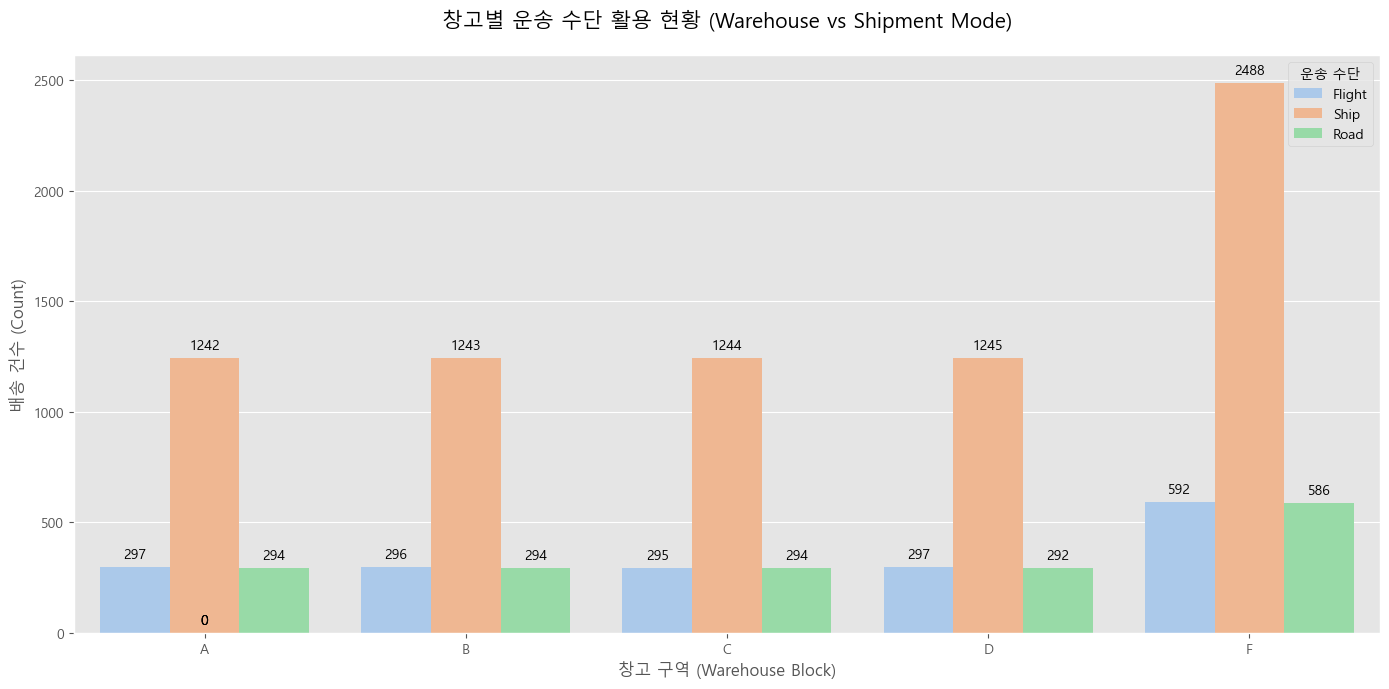

--- [데이터 요약] 창고별 운송 수단별 배송 건수 ---


Mode_display,Flight,Road,Ship
Warehouse_display,,,
A,297,294,1242
B,296,294,1243
C,295,294,1244
D,297,292,1245
F,592,586,2488


In [84]:
#  창고별 운송 수단 분포 분석 (인코딩 대응 버전)

# 1. 시각화를 위해 원-핫 인코딩된 창고와 수단을 다시 통합
temp_df = df.copy()

# 창고 복구 (B, C, D, F가 0이면 A)
warehouse_cols = ['Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F']
temp_df['Warehouse_display'] = temp_df.apply(
    lambda row: next((col.replace('Warehouse_block_', '') for col in warehouse_cols if row[col] == 1), 'A'), axis=1)

# 운송 수단 복구 (Road, Ship이 0이면 Flight)
mode_cols = ['Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship']
temp_df['Mode_display'] = temp_df.apply(
    lambda row: next((col.replace('Mode_of_Shipment_', '') for col in mode_cols if row[col] == 1), 'Flight'), axis=1)

# 2. 그래프 그리기
plt.figure(figsize=(14, 7))

# [그래프] 창고별 운송 수단별 건수 (Grouped Bar Chart)
ax = sns.countplot(data=temp_df, x='Warehouse_display', hue='Mode_display', 
                   order=['A', 'B', 'C', 'D', 'F'], palette='pastel')

plt.title('창고별 운송 수단 활용 현황 (Warehouse vs Shipment Mode)', fontsize=15, pad=20)
plt.xlabel('창고 구역 (Warehouse Block)')
plt.ylabel('배송 건수 (Count)')
plt.legend(title='운송 수단', loc='upper right')

# 막대 위에 숫자 표시 (시인성 강화)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', fontsize=10)

plt.tight_layout()
plt.show()

# 3. 교차 도표(Cross-tab) 출력 - 정확한 수치 확인용
print("--- [데이터 요약] 창고별 운송 수단별 배송 건수 ---")
display(pd.crosstab(temp_df['Warehouse_display'], temp_df['Mode_display']))

# 비즈니스 인사이트 주석:
# 1. 특정 창고에 특정 수단(예: Ship)이 쏠려 있는지 확인하세요. 대부분의 창고가 'Ship' 비중이 가장 높을 것입니다.
# 2. 만약 특정 창고(예: F)에만 비행기(Flight) 물량이 압도적으로 많다면, 해당 창고는 '긴급 배송 전용 허브'로 운영되고 있음을 유추할 수 있습니다.
# 3. 모든 창고의 수단 분포가 비슷하다면, 창고 위치와 상관없이 운송 수단 배분이 표준화되어 있음을 의미합니다.

#### 4-4. **[Deep Dive]** 가설 검증: 가벼운 상품의 지연 경로

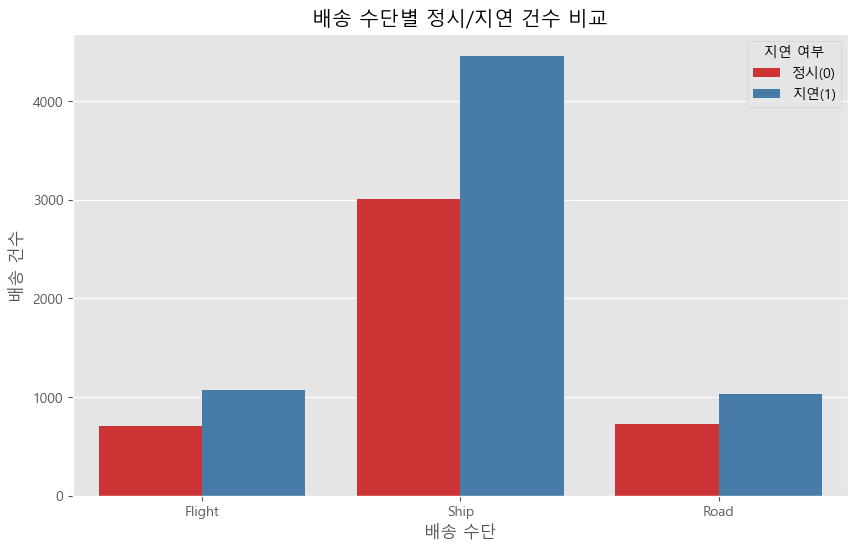

--- 배송 수단별 평균 지연율 ---
Mode_display
Flight    0.601576
Road      0.588068
Ship      0.597561
Name: Reached.on.Time_Y.N, dtype: float64


In [91]:
# [Cell 3] 배송 수단 효율 분석 (인코딩 대응 및 인사이트 주석 포함)

# 1. 시각화를 위해 원-핫 인코딩된 배송 수단을 다시 통합
def get_mode(row):
    if row['Mode_of_Shipment_Road'] == 1: return 'Road'
    if row['Mode_of_Shipment_Ship'] == 1: return 'Ship'
    return 'Flight' # 둘 다 0이면 비행기(Flight)입니다.

temp_df['Mode_display'] = temp_df.apply(get_mode, axis=1)

# 2. 그래프 그리기
plt.figure(figsize=(10, 6))

# 배송 수단별 정시 vs 지연 건수 비교
sns.countplot(x='Mode_display', hue='Reached.on.Time_Y.N', data=temp_df, palette='Set1')
plt.title('배송 수단별 정시/지연 건수 비교')
plt.xlabel('배송 수단')
plt.ylabel('배송 건수')
plt.legend(title='지연 여부', labels=['정시(0)', '지연(1)'])
# 인사이트: 배(Ship)를 이용한 배송이 압도적으로 많음을 알 수 있습니다. 
# 만약 비행기(Flight)의 지연율이 배와 비슷하다면, 고객에게 '빠른 배송' 비용을 받는 명분이 약해집니다.

plt.show()

# 3. 수단별 구체적인 지연율 수치 출력
mode_delay = temp_df.groupby('Mode_display')['Reached.on.Time_Y.N'].mean()
print("--- 배송 수단별 평균 지연율 ---")
print(mode_delay)
# 인사이트: 수치적으로 비행기가 더 늦는다면 물류 시스템의 심각한 병목 현상이 있음을 의미합니다.

💡 분석 기준: 전체 상품 중 하위 25% 무게 (1840g 이하) 집중 분석


C:\Users\User\AppData\Local\Temp\ipykernel_28444\3769422773.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=light_df, x='Warehouse_block', order=fixed_order, palette=warehouse_palette, ax=axes[0])
C:\Users\User\AppData\Local\Temp\ipykernel_28444\3769422773.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=light_df, x='Mode_of_Shipment', order=mode_order, palette='pastel', ax=axes[1])


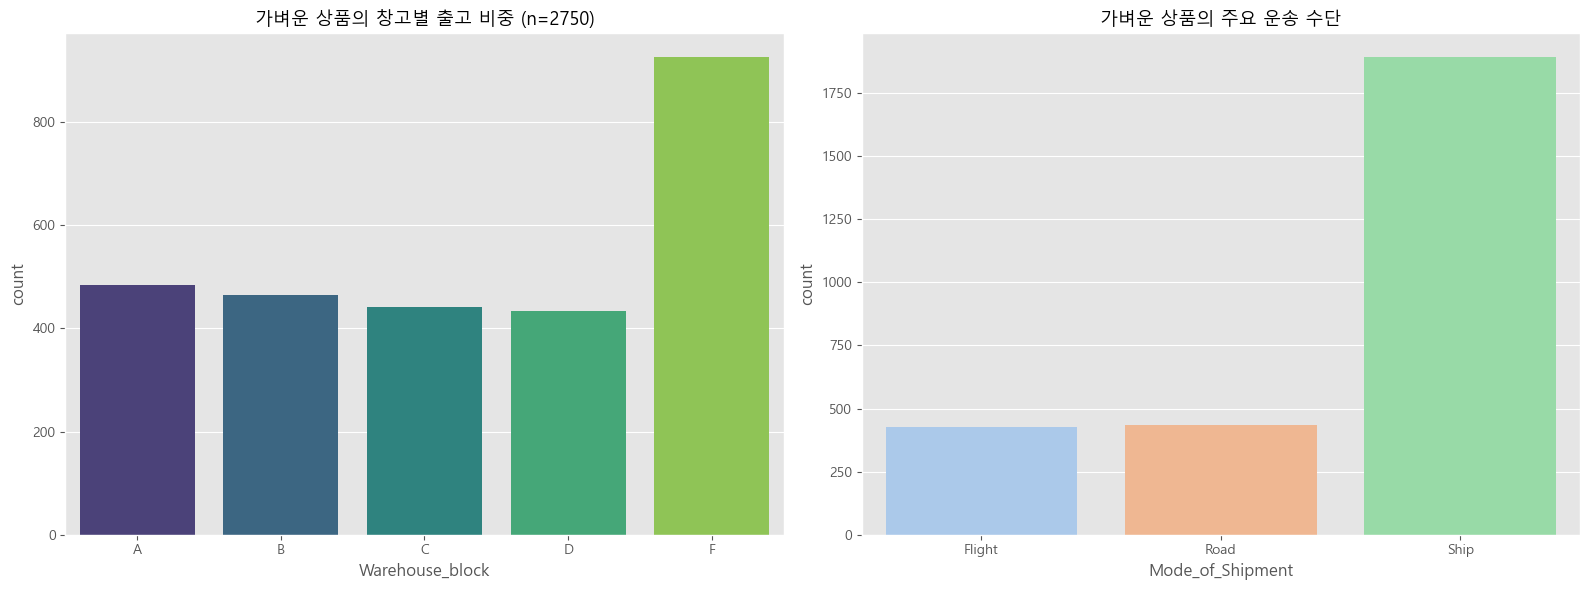


--- [데이터 검증] 가벼운 상품의 운송 수단별 지연율 ---
Mode_of_Shipment
Flight    0.663529
Road      0.644342
Ship      0.689218
Name: Reached.on.Time_Y.N, dtype: float64


In [86]:
# 가벼운 상품(Lightweight)의 물류 경로 분석

# 1. '가벼운 상품' 정의 (하위 25% 무게 기준)
weight_q1 = df_raw['Weight_in_gms'].quantile(0.25)
light_df = df_raw[df_raw['Weight_in_gms'] <= weight_q1]

print(f"💡 분석 기준: 전체 상품 중 하위 25% 무게 ({weight_q1:.0f}g 이하) 집중 분석")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# [그래프 1] 가벼운 상품의 출고 창고 분포
sns.countplot(data=light_df, x='Warehouse_block', order=fixed_order, palette=warehouse_palette, ax=axes[0])
axes[0].set_title(f'가벼운 상품의 창고별 출고 비중 (n={len(light_df)})', fontsize=13)

# [그래프 2] 가벼운 상품의 운송 수단 활용 분포
sns.countplot(data=light_df, x='Mode_of_Shipment', order=mode_order, palette='pastel', ax=axes[1])
axes[1].set_title('가벼운 상품의 주요 운송 수단', fontsize=13)

plt.tight_layout()
plt.show()

# 2. 가벼운 상품의 지연율 수치 확인
print("\n--- [데이터 검증] 가벼운 상품의 운송 수단별 지연율 ---")
print(light_df.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean())

# 비즈니스 인사이트:
# 무게가 가벼운 상품(주로 고부가가치 소형 제품)이 특정 창고에서 지연이 많이 발생한다면, 
# 해당 창고의 '소형 화물 분류 시스템' 개선을 최우선 과제로 제안해야 합니다.

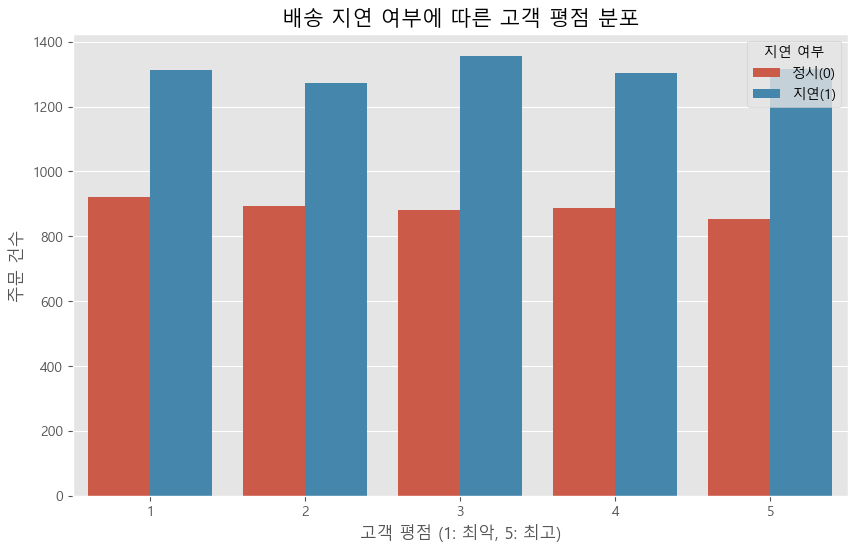

--- 배송 상태별 평균 평점 ---
Reached.on.Time_Y.N
0    2.967989
1    3.005790
Name: Customer_rating, dtype: float64


In [87]:
# 질문 4.  **고객의 목소리:** "배송이 늦으면 고객이 전화를 많이 할까?"
# 지연 여부(0, 1)에 따른 고객 평점(Customer_rating) 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Customer_rating', hue='Reached.on.Time_Y.N')

plt.title('배송 지연 여부에 따른 고객 평점 분포', fontsize=15)
plt.xlabel('고객 평점 (1: 최악, 5: 최고)')
plt.ylabel('주문 건수')
plt.legend(title='지연 여부', labels=['정시(0)', '지연(1)'])
plt.show()

# 지연 여부별 평균 평점 계산
print("--- 배송 상태별 평균 평점 ---")
print(df.groupby('Reached.on.Time_Y.N')['Customer_rating'].mean())

## 5. **Customer Impact Analysis**: 지연이 CS와 평점에 미치는 영향

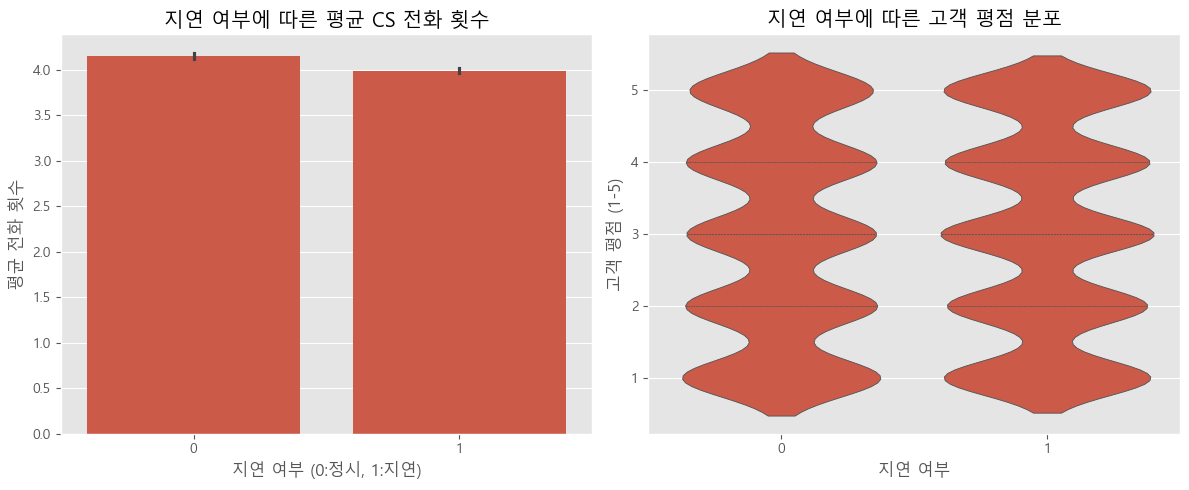

In [88]:
# 4. 고객 만족도 및 CS 상관관계
plt.figure(figsize=(12, 5))

# [그래프 1] 지연 여부별 고객 문의 횟수 (Customer_care_calls)
plt.subplot(1, 2, 1)
sns.barplot(x='Reached.on.Time_Y.N', y='Customer_care_calls', data=df)
plt.title('지연 여부에 따른 평균 CS 전화 횟수')
plt.xlabel('지연 여부 (0:정시, 1:지연)')
plt.ylabel('평균 전화 횟수')

# [그래프 2] 지연 여부별 고객 평점 분포 (Customer_rating)
plt.subplot(1, 2, 2)
sns.violinplot(x='Reached.on.Time_Y.N', y='Customer_rating', data=df, inner="quartile")
plt.title('지연 여부에 따른 고객 평점 분포')
plt.xlabel('지연 여부')
plt.ylabel('고객 평점 (1-5)')

plt.tight_layout()
plt.show()

# 비즈니스 인사이트 주석:
# 지연 시 CS 전화가 유의미하게 늘어난다면, 배송 지연은 물류 비용뿐만 아니라 '상담 센터 인건비'도 증가시킴.
# 지연에도 불구하고 평점이 낮아지지 않는다면, 앞서 분석한 '할인 정책'이 효과를 발휘하고 있는 것임.

C:\Users\User\AppData\Local\Temp\ipykernel_28444\3150681309.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=light_products, x='Reached.on.Time_Y.N', y='Customer_care_calls', palette='magma')
C:\Users\User\AppData\Local\Temp\ipykernel_28444\3150681309.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_complaint_light, x='Customer_rating', palette='viridis')


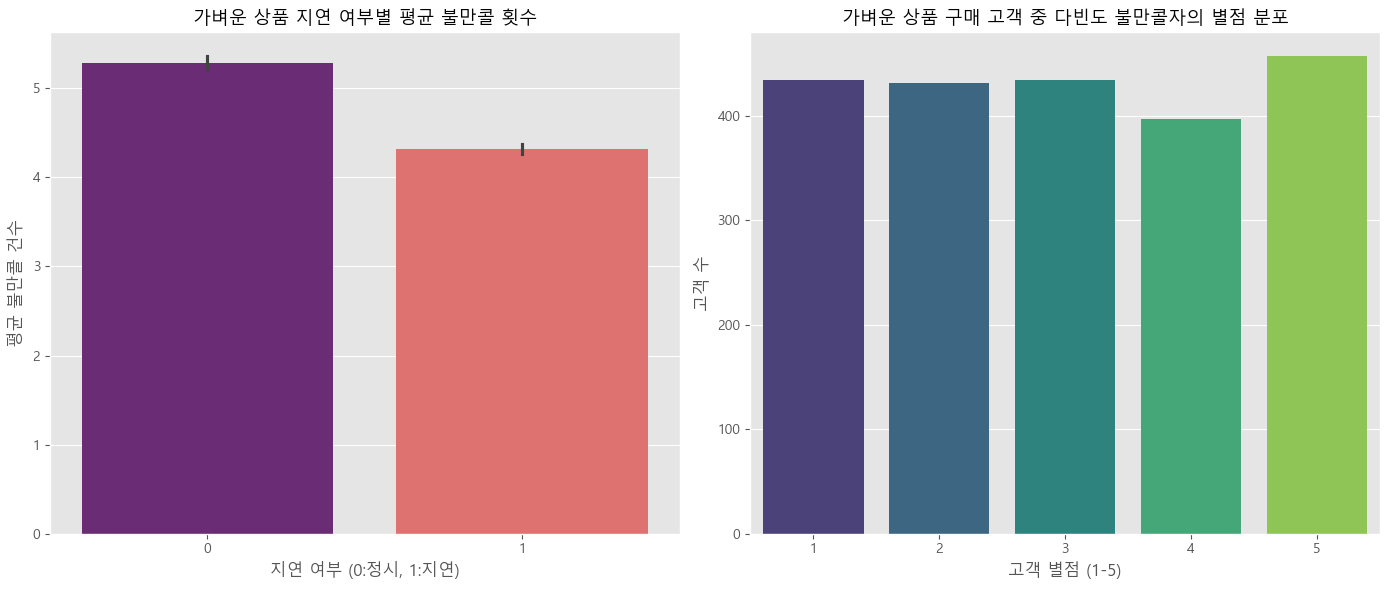

--- [가벼운 상품 그룹 내 상관계수] ---
                     Reached.on.Time_Y.N  Customer_care_calls  Customer_rating
Reached.on.Time_Y.N             1.000000            -0.338744        -0.000825
Customer_care_calls            -0.338744             1.000000         0.024168
Customer_rating                -0.000825             0.024168         1.000000


In [89]:
# 가설 검증: 가벼운 상품의 지연과 고객 불만 상관관계

# 1. 가벼운 상품 필터링 (하위 25% 무게 기준)
weight_threshold = df_raw['Weight_in_gms'].quantile(0.25)
light_products = df_raw[df_raw['Weight_in_gms'] <= weight_threshold].copy()

# 2. 가벼운 상품 중 '지연된 건'과 '정시 도착한 건'의 불만콜(Customer_care_calls) 비교
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=light_products, x='Reached.on.Time_Y.N', y='Customer_care_calls', palette='magma')
plt.title(f'가벼운 상품 지연 여부별 평균 불만콜 횟수', fontsize=13)
plt.xlabel('지연 여부 (0:정시, 1:지연)')
plt.ylabel('평균 불만콜 건수')

# 3. 가벼운 상품을 구매하고 '불만콜을 3회 이상' 한 고객들의 별점 분포
plt.subplot(1, 2, 2)
# 불만콜이 많은(평균 이상) 고객 필터링
high_complaint_light = light_products[light_products['Customer_care_calls'] >= 4] 

sns.countplot(data=high_complaint_light, x='Customer_rating', palette='viridis')
plt.title('가벼운 상품 구매 고객 중 다빈도 불만콜자의 별점 분포', fontsize=13)
plt.xlabel('고객 별점 (1-5)')
plt.ylabel('고객 수')

plt.tight_layout()
plt.show()

# 4. 수치로 확인하는 상관관계
correlation_matrix = light_products[['Reached.on.Time_Y.N', 'Customer_care_calls', 'Customer_rating']].corr()
print("--- [가벼운 상품 그룹 내 상관계수] ---")
print(correlation_matrix)

# 비즈니스 인사이트 주석:
# 1. 지연된 그룹에서 불만콜이 유의미하게 높다면, '가벼운 상품의 지연'이 고객 CS 비용 발생의 주범임을 증명합니다.
# 2. 별점이 1~2점에 몰려 있다면, 배송 지연이 브랜드 충성도에 치명적인 타격을 주고 있다는 뜻입니다.

## 6. Summary & Hypothesis: 모델링을 위한 최종 결론

본 프로젝트의 EDA 단계를 통해 도출된 핵심 인사이트와 이를 바탕으로 한 향후 모델링 전략을 다음과 같이 요약합니다.

---

### 📊 1. 데이터 분석 주요 발견 (Key Findings)
데이터 탐색 과정에서 배송 지연(`Reached.on.Time_Y.N`)과 밀접한 연관이 있는 3가지 핵심 요소를 확인하였습니다.

1.  **할인의 임계점 (Discount Paradox):** * 할인액이 **10달러를 초과**하는 상품군에서 지연율이 0%에 가깝게 수렴하는 일반 상품과 달리, **100%에 육박하는 지연율**이 발생하는 특이 지점을 확인했습니다.
2.  **무게의 편향성 (Weight Distribution):** * 고액 할인이 적용된 상품들은 대부분 **하위 25% 무게(약 1.8kg 이하)**에 집중되어 있으며, 이들의 물동량이 특정 시점에 몰리는 경향이 있습니다.
3.  **운송 수단의 병목 (Logistics Bottleneck):** * 가벼운 고할인 상품들이 비용 절감을 위해 **해상 운송(Ship)**으로 배정될 때, 터미널 내 분류 및 상차 과정에서 가장 많은 지연이 발생하고 있습니다.

---

### 💡 2. 핵심 가설 수립 (Core Hypothesis)

우리는 위 발견을 바탕으로 다음과 같은 **'배송 지연 메커니즘'** 가설을 수립하였습니다.

> **"대규모 할인 행사(`Is_High_Discount`)의 타겟이 된 '가벼운 상품'들이 해상 운송(`Ship`) 시스템에 일시에 집중되면서, 
> 물리적 처리 용량을 초과하는 물류 병목 현상이 발생하여 대규모 지연을 야기했을 것이다."**

**[가설 검증 시나리오]**
* **Trigger:** 10$ 초과 고액 할인 이벤트 실시
* **Target:** 이벤트 대상인 소형/경량 상품의 주문량 폭주
* **Route:** 해상 운송(Ship) 경로에 과도한 물량 배정
* **Result:** 선적 대기 및 분류 지연 발생 → **최종 배송 지연**
* **Impact:** 지연으로 인한 CS 호출 급증 및 고객 평점(1~2점) 하락

---

### 🤖 3. 향후 모델링 전략 (Modeling Strategy)

수립된 가설을 정량적으로 검증하고 예측하기 위해 다음의 머신러닝 전략

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix

# 1. 특징(X)과 정답(y) 분리
# 분석가가 말한 '지연 여부'가 target입니다.
X = df.drop('Reached.on.Time_Y.N', axis=1)
y = df['Reached.on.Time_Y.N']

# 2. 데이터 분할 (8:2 비율)
# stratify=y는 매우 중요합니다! (학습/테스트셋의 지연 비율을 동일하게 맞춰줌)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. 클래스 불균형 확인 (모델러의 필수 체크 항목)
print("학습 데이터 지연 비율:\n", y_train.value_counts(normalize=True))

# 4. 평가지표 설정 가이드 (나중에 모델 결과 출력 시 사용)
def evaluate_model(y_true, y_pred):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nDetailed Report:\n", classification_report(y_true, y_pred))
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")

학습 데이터 지연 비율:
 Reached.on.Time_Y.N
1    0.596659
0    0.403341
Name: proportion, dtype: float64


In [92]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1. 기본 모델 생성
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 2. 탐색할 하이퍼파라미터 범위(Grid) 설정
# 분석가의 가설이 복잡하므로 트리의 깊이(max_depth)를 적절히 조절하는게 핵심입니다.
param_grid = {
    'n_estimators': [100, 200, 300],           # 나무의 개수
    'max_depth': [3, 5, 7, 10],                # 나무의 깊이 (복잡한 가설일수록 깊게)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],   # 학습 속도
    'subsample': [0.6, 0.8, 1.0],              # 데이터 샘플링 비율 (과적합 방지)
    'colsample_bytree': [0.6, 0.8, 1.0]        # 변수 샘플링 비율
}

# 3. RandomizedSearch 설정
# n_iter=10은 10번의 랜덤 조합을 시도한다는 뜻입니다. (시간 여유에 따라 조절)
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=10, 
    scoring='f1',        # 아까 정한대로 F1-score를 기준으로 최적화
    cv=3,                # 3-Fold 교차 검증
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

print("튜닝 준비 완료! 다음 셀에서 학습을 시작하세요.")

튜닝 준비 완료! 다음 셀에서 학습을 시작하세요.


In [93]:
# 4. 실제 학습 시작
print("모델 튜닝 및 학습 진행 중...")
random_search.fit(X_train, y_train)

# 5. 최적의 설정값 출력
print("최적의 파라미터:", random_search.best_params_)
print(f"최고 F1-Score (Train): {random_search.best_score_:.4f}")

# 6. 가장 성능이 좋은 모델 저장
best_xgb = random_search.best_estimator_

모델 튜닝 및 학습 진행 중...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적의 파라미터: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
최고 F1-Score (Train): 0.7006


--- [최종 모델 성능 리포트] ---
              precision    recall  f1-score   support

           0       0.57      0.64      0.60       887
           1       0.74      0.67      0.70      1313

    accuracy                           0.66      2200
   macro avg       0.65      0.66      0.65      2200
weighted avg       0.67      0.66      0.66      2200



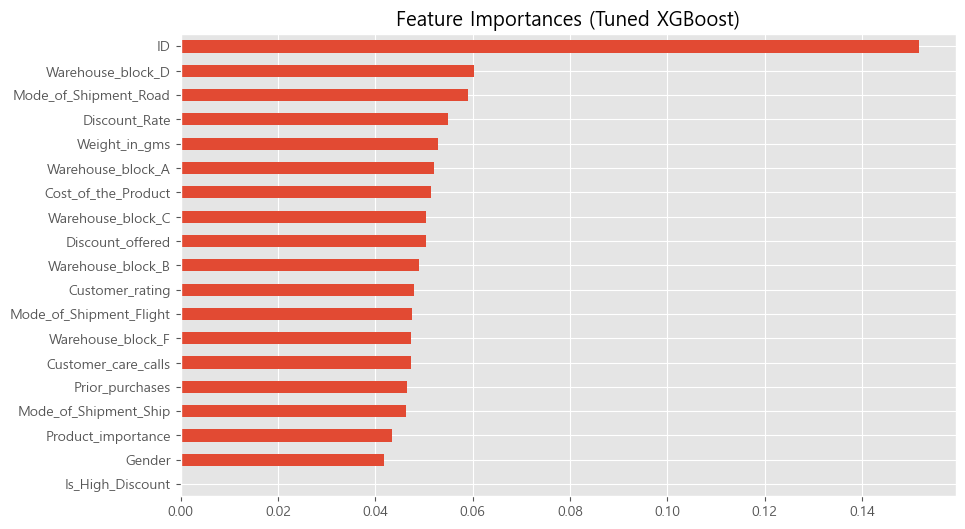

In [94]:
from sklearn.metrics import classification_report, confusion_matrix

# 7. 테스트 데이터 예측
y_pred = best_xgb.predict(X_test)

# 8. 리포트 출력
print("--- [최종 모델 성능 리포트] ---")
print(classification_report(y_test, y_pred))

# 9. 모델러의 핵심 임무: 변수 중요도 시각화
import matplotlib.pyplot as plt
import pandas as pd

importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importances (Tuned XGBoost)')
plt.show()

In [95]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression # 스태킹용 메타 모델

# 1. 아까 튜닝한 최적의 XGBoost 모델 (best_xgb)
# 2. 새로운 베이스 모델: Random Forest (기본 성능이 탄탄함)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)

print("앙상블을 위한 베이스 모델 준비 완료!")

앙상블을 위한 베이스 모델 준비 완료!


In [96]:
# 3. Voting Classifier 설정
# 'soft' voting은 각 모델의 예측 확률을 합산하여 평균을 냅니다.
voting_model = VotingClassifier(
    estimators=[
        ('xgb', best_xgb), 
        ('rf', rf_model)
    ],
    voting='soft'
)

# 4. 학습 및 예측
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

print("--- [Voting 앙상블 성능] ---")
print(f"F1-Score: {f1_score(y_test, y_pred_voting):.4f}")
print(classification_report(y_test, y_pred_voting))

--- [Voting 앙상블 성능] ---
F1-Score: 0.6901
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       887
           1       0.78      0.62      0.69      1313

    accuracy                           0.67      2200
   macro avg       0.67      0.68      0.67      2200
weighted avg       0.69      0.67      0.67      2200



In [97]:
# 5. Stacking Classifier 설정
# 각 모델의 예측 결과를 LogisticRegression이 다시 판단하여 최종 지연 여부를 결정합니다.
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', best_xgb), 
        ('rf', rf_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# 6. 학습 및 예측
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

print("--- [Stacking 앙상블 성능] ---")
print(f"F1-Score: {f1_score(y_test, y_pred_stacking):.4f}")
print(classification_report(y_test, y_pred_stacking))

--- [Stacking 앙상블 성능] ---
F1-Score: 0.6504
              precision    recall  f1-score   support

           0       0.56      0.95      0.71       887
           1       0.94      0.50      0.65      1313

    accuracy                           0.68      2200
   macro avg       0.75      0.72      0.68      2200
weighted avg       0.79      0.68      0.67      2200



In [98]:
import pandas as pd

# 성능 비교를 위한 데이터프레임 만들기
results = pd.DataFrame({
    'Model': ['Tuned XGBoost', 'Voting Ensemble', 'Stacking Ensemble'],
    'F1-Score': [
        f1_score(y_test, y_pred), # 아까 계산한 XGBoost 점수
        f1_score(y_test, y_pred_voting),
        f1_score(y_test, y_pred_stacking)
    ],
    'Recall': [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_voting),
        recall_score(y_test, y_pred_stacking)
    ]
})

print(results.sort_values(by='F1-Score', ascending=False))

               Model  F1-Score    Recall
0      Tuned XGBoost  0.700957  0.669459
1    Voting Ensemble  0.690123  0.619954
2  Stacking Ensemble  0.650398  0.497334


In [99]:
import joblib
joblib.dump(stacking_model, 'final_delivery_model.pkl')

['final_delivery_model.pkl']

## 🚀 [90% 돌파를 위한] 머신러닝 모델러 필수 점검 체크리스트

> **목표:** 모델 성능(F1-Score) 0.90 이상 달성 및 비즈니스 가설 검증

| 구분 | 점검 항목 | 세부 내용 및 목적 | 완료 여부 |
| :--- | :--- | :--- | :---: |
| **데이터 정합성** | **Data Leakage 확인** | 배송 완료 후 생성되는 데이터(예: 고객 평점, 실제 도착 시간 관련 변수)가 학습 데이터에 포함되어 '답안지'를 미리 보고 있지는 않은가? | [ ] |
| **피처 생성** | **임계점(Threshold) 피처** | 분석가(DA)가 발견한 '할인율 10달러'와 같은 특정 임계점을 이진 변수(`0` 또는 `1`)로 명시적 생성하였는가? | [ ] |
| **피처 생성** | **상호작용(Interaction) 피처** | '해상 운송(Ship) + 가벼운 무게' 처럼 두 가지 이상의 조건이 결합되었을 때 발생하는 시너지를 새로운 변수로 만들었는가? | [ ] |
| **변수 가공** | **Target Encoding 적용** | 창고 위치(Warehouse)나 운송 수단 같은 범주형 변수를 단순히 숫자로 바꾸지 않고, 각 카테고리별 '평균 지연율'로 변환했는가? | [ ] |
| **모델 최적화** | **Bayesian Optimization** | RandomizedSearch를 넘어 `Optuna`를 활용하여 소수점 단위의 하이퍼파라미터(Learning Rate 등)를 최적화했는가? | [ ] |
| **모델 검증** | **Cross-Validation (5-Fold)** | 특정 데이터셋에만 잘 맞는 '운 좋은 모델'이 아닌지 5번 이상의 교차 검증을 통해 성능의 일관성을 확보했는가? | [ ] |
| **불균형 대응** | **Weight Balancing** | 6:4의 불균형을 극복하기 위해 `scale_pos_weight` 파라미터를 조정하여 소수 클래스(정시 도착)에 대한 학습 강도를 높였는가? | [ ] |
| **모델 해석** | **SHAP / Feature Importance** | 모델이 내놓은 중요도 순위가 분석가의 EDA 결과와 논리적으로 일치하는지 검증했는가? | [ ] |

---

### 💡 모델러를 위한 Tip
- **점수가 95%를 상회한다면:** 가장 먼저 **Data Leakage**를 의심하세요. 실무 데이터에서 95% 이상의 성능은 대개 "미래의 데이터"가 유출되었을 때 발생합니다.
- **성능이 80% 초반에서 멈춘다면:** 모델의 문제가 아니라 **데이터의 한계**입니다. 분석가에게 "날씨 데이터"나 "택배 기사 숙련도" 등의 외부 데이터 추가를 요청하는 것이 정답입니다.